In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import dask 
import hdbscan
import seaborn as sns
import dask.dataframe as dd
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from scipy.fftpack import fft
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.neighbors import NearestNeighbors
from joblib import Parallel, delayed
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from itertools import product
from dask import delayed
from dask.distributed import Client, progress


In [3]:
# Read the parquet file
filtered_transactions = pd.read_parquet('filtered_transactions.parquet')
# Display the first few rows
print(filtered_transactions.head())


                                         CUST_CUSTNO  VALUEDATE  \
0  00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608... 2023-08-05   
1  00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608... 2023-08-06   
2  00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608... 2023-08-10   
3  00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608... 2023-08-11   
4  00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608... 2023-08-13   

   TOTAL_RECEIVED  TOTAL_SENT  TOTAL_ABSOLUTE  
0          1500.0      -300.0          1800.0  
1             0.0     -1000.0          1000.0  
2         12717.6     -2063.0         14780.6  
3             0.0     -3439.0          3439.0  
4             0.0     -2500.0          2500.0  


In [4]:
# Take the absolute value of the columns before applying log transformation
filtered_transactions['TOTAL_SENT'] = filtered_transactions['TOTAL_SENT'].abs()
filtered_transactions['TOTAL_RECEIVED'] = filtered_transactions['TOTAL_RECEIVED'].abs()

# Apply the log transformation
filtered_transactions['log_TOTAL_SENT'] = np.log1p(filtered_transactions['TOTAL_SENT'])
filtered_transactions['log_TOTAL_RECEIVED'] = np.log1p(filtered_transactions['TOTAL_RECEIVED'])



In [5]:
# Prepare the data for clustering
features = filtered_transactions[['log_TOTAL_RECEIVED', 'log_TOTAL_SENT' ]].values

In [6]:
# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [7]:
features_scaled.shape

(28997435, 2)

In [8]:
# Set the number of clusters
n_clusters = 3

In [9]:
# Apply Fuzzy C-Means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    features_scaled.T, c=n_clusters, m=2, error=0.005, maxiter=1000, init=None)

In [10]:
# Assign clusters to each transaction based on the highest membership
cluster_labels = np.argmax(u, axis=0)

In [11]:
# Add the cluster labels to the DataFrame
cmeans_transactions_filtered = filtered_transactions.copy()
cmeans_transactions_filtered['cluster'] = cluster_labels
cmeans_transactions_filtered

,CUST_CUSTNO,VALUEDATE,TOTAL_RECEIVED,TOTAL_SENT,TOTAL_ABSOLUTE,log_TOTAL_SENT,log_TOTAL_RECEIVED,cluster
0,00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608...,2023-08-05,1500.00,300.00,1800.00,5.707110,7.313887,1
1,00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608...,2023-08-06,0.00,1000.00,1000.00,6.908755,0.000000,2
2,00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608...,2023-08-10,12717.60,2063.00,14780.60,7.632401,9.450821,1
3,00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608...,2023-08-11,0.00,3439.00,3439.00,8.143227,0.000000,2
4,00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608...,2023-08-13,0.00,2500.00,2500.00,7.824446,0.000000,2
...,...,...,...,...,...,...,...,...
28997430,fffff9df57f43b816e9ae9dd31699ccbeba7668c731de1...,2023-12-03,0.00,10000.00,10000.00,9.210440,0.000000,2
28997431,fffff9df57f43b816e9ae9dd31699ccbeba7668c731de1...,2023-12-31,0.46,0.00,0.46,0.000000,0.378436,0
28997432,fffff9df57f43b816e9ae9dd31699ccbeba7668c731de1...,2024-01-06,142350.14,130000.00,272350.14,11.775297,11.866052,1
28997433,fffff9df57f43b816e9ae9dd31699ccbeba7668c731de1...,2024-01-10,142429.56,242351.56,384781.12,12.398149,11.866610,1


In [12]:
# Count the number of transactions in each clus
cmeans_transactions_filtered['cluster'].value_counts()

cluster
2    11432820
1    10535353
0     7029262
Name: count, dtype: int64

In [13]:
# Calculate Euclidean distance from each point to its assigned cluster centroid
def euclidean_distance(point, centroid):
    return np.linalg.norm(point - centroid)

In [14]:
# Compute distances
distances = np.array([euclidean_distance(features_scaled[i], cntr[cluster_labels[i]]) for i in range(len(features_scaled))])
cmeans_transactions_filtered['distance_from_centroid'] = distances

In [15]:
# Sort transactions based on distance (higher distance = more anomalous)
cmeans_transactions_sorted = cmeans_transactions_filtered.sort_values(by='distance_from_centroid', ascending=False)

# Step 1: Display the first few sorted transactions to see the highest distance anomalies
print("Top anomalies sorted by distance:")
print(cmeans_transactions_sorted[['CUST_CUSTNO', 'VALUEDATE', 'distance_from_centroid']])



Top anomalies sorted by distance:
                                                CUST_CUSTNO  VALUEDATE  \
15110756  857444eeac05c029c54bc6f76ce1a4c02dab7d17484011... 2023-10-25   
1525778   0d743612b689a18c7441cb670a8809b6a7da8706513ca9... 2023-10-25   
6709139   3b5371973cacd2d0c98194f98c0553d85e2091714e5064... 2024-01-09   
6709132   3b5371973cacd2d0c98194f98c0553d85e2091714e5064... 2023-10-09   
19875346  afa142b3c0e3f7e84b916b038d88d5262ed39fa3623063... 2023-11-18   
...                                                     ...        ...   
10532512  5cec3c6a2990adb67c915cd77cf65441d78dead82a4e76... 2023-12-26   
10734900  5ebe8a99aff6bdf3c6bdbe8ad20791197e25b84e53a7df... 2023-12-29   
7666941   43bfc06ee605270711e9b0adeefd9f74ed33a43334f4f2... 2023-09-20   
11931058  6946f3dc2fc1b545b3153ca5b28849d2a0ebeaf6ccb121... 2023-09-18   
7163903   3f5b07b8bbf907362349c766303a284dfdaa82f6fe73ff... 2023-12-27   

          distance_from_centroid  
15110756                4.616130  
1525778


Summary of distances from centroid:
Min distance: 0.0001
Max distance: 4.6161
Mean distance: 0.5847
Standard deviation of distances: 0.4204


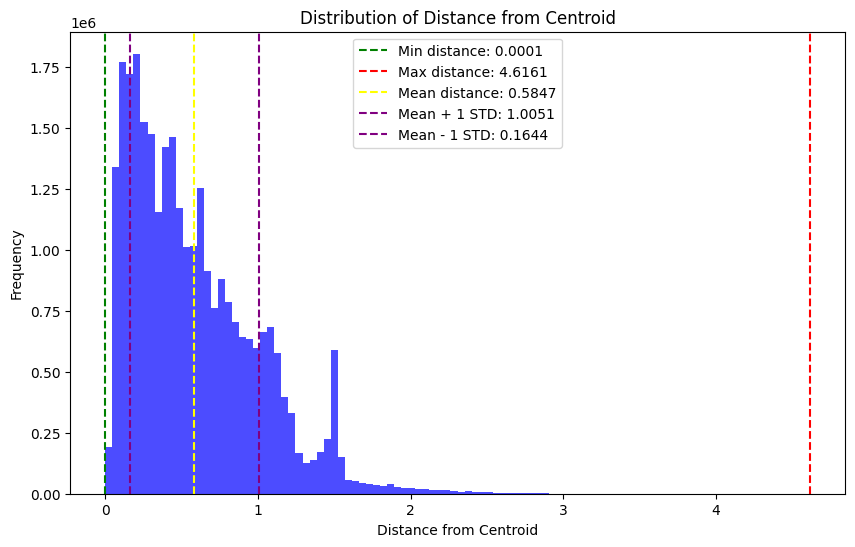

In [41]:
# Step 2: Generate summary statistics for distance_from_centroid
min_distance = cmeans_transactions_sorted['distance_from_centroid'].min()
max_distance = cmeans_transactions_sorted['distance_from_centroid'].max()
mean_distance = cmeans_transactions_sorted['distance_from_centroid'].mean()
std_distance = cmeans_transactions_sorted['distance_from_centroid'].std()

# Summary of distances
print("\nSummary of distances from centroid:")
print(f"Min distance: {min_distance:.4f}")
print(f"Max distance: {max_distance:.4f}")
print(f"Mean distance: {mean_distance:.4f}")
print(f"Standard deviation of distances: {std_distance:.4f}")

# Step 3: Plot histogram of distances
plt.figure(figsize=(10, 6))
plt.hist(cmeans_transactions_sorted['distance_from_centroid'], bins=100, color='blue', alpha=0.7)
plt.axvline(min_distance, color='green', linestyle='--', label=f"Min distance: {min_distance:.4f}")
plt.axvline(max_distance, color='red', linestyle='--', label=f"Max distance: {max_distance:.4f}")
plt.axvline(mean_distance, color='yellow', linestyle='--', label=f"Mean distance: {mean_distance:.4f}")
plt.axvline(mean_distance + std_distance, color='purple', linestyle='--', label=f"Mean + 1 STD: {mean_distance + std_distance:.4f}")
plt.axvline(mean_distance - std_distance, color='purple', linestyle='--', label=f"Mean - 1 STD: {mean_distance - std_distance:.4f}")
plt.xlabel('Distance from Centroid')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Distance from Centroid')
plt.show()


# Rule 15 threshold

In [28]:
cmeans_rule_15 = cmeans_transactions_sorted.copy()



Total anomalies based on threshold (>= 2.5026 distance): 28667

Summary of anomalies based on threshold distance:
                                                CUST_CUSTNO  VALUEDATE  \
15110756  857444eeac05c029c54bc6f76ce1a4c02dab7d17484011... 2023-10-25   
1525778   0d743612b689a18c7441cb670a8809b6a7da8706513ca9... 2023-10-25   
6709139   3b5371973cacd2d0c98194f98c0553d85e2091714e5064... 2024-01-09   
6709132   3b5371973cacd2d0c98194f98c0553d85e2091714e5064... 2023-10-09   
19875346  afa142b3c0e3f7e84b916b038d88d5262ed39fa3623063... 2023-11-18   
6709138   3b5371973cacd2d0c98194f98c0553d85e2091714e5064... 2024-01-01   
6709130   3b5371973cacd2d0c98194f98c0553d85e2091714e5064... 2023-10-02   
15174004  860f56cfef511a0226c06e7d27cb51fdc39881c6f7dc5a... 2023-11-30   
15174003  860f56cfef511a0226c06e7d27cb51fdc39881c6f7dc5a... 2023-11-08   
23138100  cc0b0d019b63002c450bc459d5b82713ca95f477e8ba82... 2023-08-10   

          distance_from_centroid  is_anomaly_threshold  
15110756     

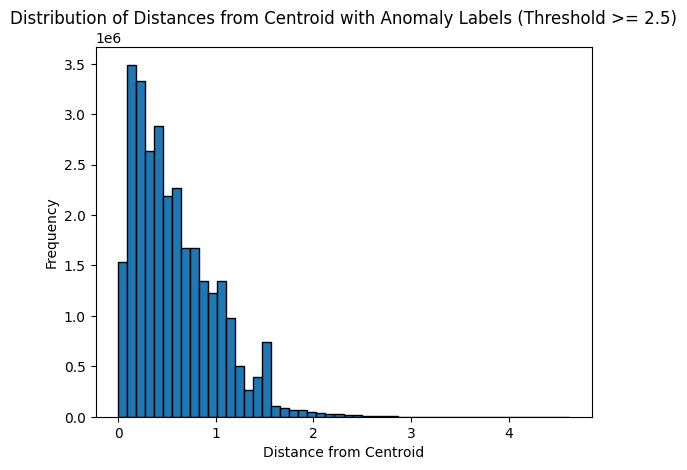

In [29]:
# Step 2: Define the minimum threshold for anomaly assignment (starting at distance 2.57) the adjusting it according to the analysis
threshold_distance = 2.50260
max_distance = cmeans_rule_15['distance_from_centroid'].max()

# Step 3: Create a linspace from the threshold to the max distance
# We generate the linspace between the threshold and the max distance
num_bins = len(cmeans_rule_15)  # Number of bins will be equal to the number of transactions
distance_range = np.linspace(threshold_distance, max_distance, num_bins)

# Step 4: Assign anomalies based on the distance using the linspace
def assign_anomalies_with_threshold(df, distance_column, distance_range, threshold):
    # Create an empty list to store the anomaly labels
    anomaly_labels = []
    
    # Loop over the sorted distances and assign anomalies progressively starting from the threshold distance
    for i, distance in enumerate(df[distance_column]):
        # If the distance is above or equal to the threshold, assign it as an anomaly
        if distance >= threshold:  # Anomalies for distances >= 2.5
            anomaly_labels.append(True)
        else:
            anomaly_labels.append(False)
    
    # Assign the anomaly labels to the dataframe
    df['is_anomaly_threshold'] = anomaly_labels
    return df

# Apply the function to the sorted DataFrame (based on distance)
cmeans_rule_15 = assign_anomalies_with_threshold(cmeans_rule_15, 'distance_from_centroid', distance_range, threshold_distance)

# Step 5: Summary of anomalies based on threshold
total_anomalies_threshold = cmeans_rule_15['is_anomaly_threshold'].sum()
print(f"\nTotal anomalies based on threshold (>= {threshold_distance} distance): {total_anomalies_threshold}")

# Display the anomalies (optional)
anomalies_summary_threshold = cmeans_rule_15[cmeans_rule_15['is_anomaly_threshold']]
print("\nSummary of anomalies based on threshold distance:")
print(anomalies_summary_threshold[['CUST_CUSTNO', 'VALUEDATE', 'distance_from_centroid', 'is_anomaly_threshold']].head(10))

# Optional: Visualize the distribution of distances with the anomaly assignments
plt.hist(cmeans_rule_15['distance_from_centroid'], bins=50, edgecolor='k')
plt.title('Distribution of Distances from Centroid with Anomaly Labels (Threshold >= 2.5)')
plt.xlabel('Distance from Centroid')
plt.ylabel('Frequency')
plt.show()


In [30]:
# Rule-based anomalies
rule_15_anomalies =cmeans_rule_15[
    (cmeans_rule_15['TOTAL_RECEIVED'] >= 6000000) &
    (cmeans_rule_15['TOTAL_SENT'].abs() >= 0.95 * cmeans_rule_15['TOTAL_RECEIVED'])
]
rule_15_anomalies

,CUST_CUSTNO,VALUEDATE,TOTAL_RECEIVED,TOTAL_SENT,TOTAL_ABSOLUTE,log_TOTAL_SENT,log_TOTAL_RECEIVED,cluster,distance_from_centroid,is_anomaly_threshold
15110756,857444eeac05c029c54bc6f76ce1a4c02dab7d17484011...,2023-10-25,1.984136e+09,1.984135e+09,3.968271e+09,21.408449,21.408449,2,4.616129,True
1525778,0d743612b689a18c7441cb670a8809b6a7da8706513ca9...,2023-10-25,1.683219e+09,1.683209e+09,3.366428e+09,21.243968,21.243974,2,4.556465,True
6709139,3b5371973cacd2d0c98194f98c0553d85e2091714e5064...,2024-01-09,1.162635e+09,1.162635e+09,2.325269e+09,20.873954,20.873954,2,4.422245,True
6709132,3b5371973cacd2d0c98194f98c0553d85e2091714e5064...,2023-10-09,1.161027e+09,1.161027e+09,2.322054e+09,20.872570,20.872571,2,4.421743,True
19875346,afa142b3c0e3f7e84b916b038d88d5262ed39fa3623063...,2023-11-18,1.027001e+09,1.232827e+09,2.259828e+09,20.932576,20.749909,2,4.414951,True
...,...,...,...,...,...,...,...,...,...,...
5809380,336177bddf882dfd1f3abe689cb7d6437057b15968cc1c...,2023-12-29,6.025900e+06,5.775800e+06,1.180170e+07,15.569188,15.611578,2,2.504650,True
15622004,8a0361686ef90772cdf90b32ec6a8676407453629c67e6...,2023-12-15,6.022261e+06,5.776104e+06,1.179837e+07,15.569240,15.610974,2,2.504566,True
12711569,7038c33131c655e6bf330c99c78a6d2fd104f511dacad0...,2024-01-19,6.000000e+06,5.750000e+06,1.175000e+07,15.564711,15.607270,2,2.503053,True
4647447,291711953708b654d8487cbb774928b4f3d8570ab16cc7...,2023-09-15,6.001697e+06,5.737250e+06,1.173895e+07,15.562491,15.607553,2,2.502642,True


Total Rule 15 anomalies with 'is_anomaly_threshold' label as anomaly: 20720

Summary of 'distance_from_centroid' for Rule 15 anomalies:
count    20720.000000
mean         2.767975
std          0.266397
min          2.502600
25%          2.591393
50%          2.690329
75%          2.845388
max          4.616129
Name: distance_from_centroid, dtype: float64


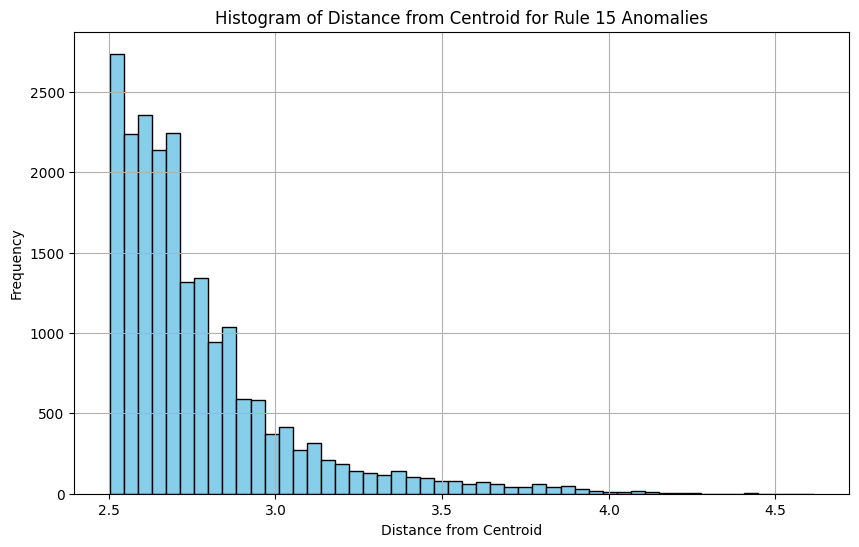


Sample of Rule 15 anomalies with 'is_anomaly_threshold' label as anomaly:
                                                CUST_CUSTNO  VALUEDATE  \
15110756  857444eeac05c029c54bc6f76ce1a4c02dab7d17484011... 2023-10-25   
1525778   0d743612b689a18c7441cb670a8809b6a7da8706513ca9... 2023-10-25   
6709139   3b5371973cacd2d0c98194f98c0553d85e2091714e5064... 2024-01-09   
6709132   3b5371973cacd2d0c98194f98c0553d85e2091714e5064... 2023-10-09   
19875346  afa142b3c0e3f7e84b916b038d88d5262ed39fa3623063... 2023-11-18   
6709138   3b5371973cacd2d0c98194f98c0553d85e2091714e5064... 2024-01-01   
6709130   3b5371973cacd2d0c98194f98c0553d85e2091714e5064... 2023-10-02   
15174004  860f56cfef511a0226c06e7d27cb51fdc39881c6f7dc5a... 2023-11-30   
15174003  860f56cfef511a0226c06e7d27cb51fdc39881c6f7dc5a... 2023-11-08   
23138100  cc0b0d019b63002c450bc459d5b82713ca95f477e8ba82... 2023-08-10   

          TOTAL_RECEIVED    TOTAL_SENT  is_anomaly_threshold  \
15110756    1.984136e+09  1.984135e+09        

In [33]:
# Filter Rule 15 anomalies that are labeled as anomalies based on the threshold
rule_15_anomalies_with_label = rule_15_anomalies[
    rule_15_anomalies['is_anomaly_threshold'] == True
]

# Count of Rule 15 anomalies that are labeled as anomalies by the threshold
print(f"Total Rule 15 anomalies with 'is_anomaly_threshold' label as anomaly: {len(rule_15_anomalies_with_label)}")

# Summary of 'distance_from_centroid' for the Rule 15 anomalies
distance_summary = rule_15_anomalies_with_label['distance_from_centroid'].describe()

# Display summary statistics for the distance from centroid
print("\nSummary of 'distance_from_centroid' for Rule 15 anomalies:")
print(distance_summary)

# Plot the histogram of 'distance_from_centroid' for Rule 15 anomalies
plt.figure(figsize=(10, 6))
plt.hist(rule_15_anomalies_with_label['distance_from_centroid'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Distance from Centroid for Rule 15 Anomalies')
plt.xlabel('Distance from Centroid')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Optionally, display a sample of Rule 15 anomalies with the 'is_anomaly_threshold' label
print("\nSample of Rule 15 anomalies with 'is_anomaly_threshold' label as anomaly:")
print(rule_15_anomalies_with_label[['CUST_CUSTNO', 'VALUEDATE', 'TOTAL_RECEIVED', 'TOTAL_SENT', 'is_anomaly_threshold', 'distance_from_centroid']].head(10))


In [35]:
# Add a column to indicate whether a transaction belongs to Rule 15
cmeans_rule_15['is_rule_15'] = cmeans_rule_15.index.isin(rule_15_anomalies.index)

# True Positives (TP): Rule 15 anomalies that are labeled as anomalies based on the threshold
rule_15_anomalies_with_label = rule_15_anomalies[
    rule_15_anomalies['is_anomaly_threshold'] == True
]

# False Positives (FP): Non-Rule 15 anomalies labeled as anomalies
non_rule_15_anomalies = cmeans_rule_15[~cmeans_rule_15.index.isin(rule_15_anomalies.index)]
false_positive_anomalies = non_rule_15_anomalies[non_rule_15_anomalies['is_anomaly_threshold'] == True]

# False Negatives (FN): Rule 15 anomalies that are not labeled as anomalies by threshold
false_negative_anomalies = rule_15_anomalies[rule_15_anomalies['is_anomaly_threshold'] == False]

# Precision and Recall calculations
TP = len(rule_15_anomalies_with_label)
FP = len(false_positive_anomalies)
FN = len(false_negative_anomalies)

precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0

# Print the results
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")

# Display a sample of the dataset with the new column
print("\nSample of transactions with Rule 15 indicator:")
print(cmeans_rule_15[['CUST_CUSTNO', 'VALUEDATE', 'distance_from_centroid', 'is_anomaly_threshold', 'is_rule_15']])


Precision: 0.7228
Recall: 1.0000
True Positives (TP): 20720
False Positives (FP): 7947
False Negatives (FN): 0

Sample of transactions with Rule 15 indicator:
                                                CUST_CUSTNO  VALUEDATE  \
15110756  857444eeac05c029c54bc6f76ce1a4c02dab7d17484011... 2023-10-25   
1525778   0d743612b689a18c7441cb670a8809b6a7da8706513ca9... 2023-10-25   
6709139   3b5371973cacd2d0c98194f98c0553d85e2091714e5064... 2024-01-09   
6709132   3b5371973cacd2d0c98194f98c0553d85e2091714e5064... 2023-10-09   
19875346  afa142b3c0e3f7e84b916b038d88d5262ed39fa3623063... 2023-11-18   
...                                                     ...        ...   
10532512  5cec3c6a2990adb67c915cd77cf65441d78dead82a4e76... 2023-12-26   
10734900  5ebe8a99aff6bdf3c6bdbe8ad20791197e25b84e53a7df... 2023-12-29   
7666941   43bfc06ee605270711e9b0adeefd9f74ed33a43334f4f2... 2023-09-20   
7163903   3f5b07b8bbf907362349c766303a284dfdaa82f6fe73ff... 2023-12-27   
11931058  6946f3dc2fc1b545b

In [48]:
cmeans_rule_15.to_parquet('cmeans_anomalies_rule15.parquet')


# Farest distance filter

In [16]:
Cmeans_transcations_optimized=cmeans_transactions_sorted.copy()
Cmeans_transcations_optimized

,CUST_CUSTNO,VALUEDATE,TOTAL_RECEIVED,TOTAL_SENT,TOTAL_ABSOLUTE,log_TOTAL_SENT,log_TOTAL_RECEIVED,cluster,distance_from_centroid
15110756,857444eeac05c029c54bc6f76ce1a4c02dab7d17484011...,2023-10-25,1.984136e+09,1.984135e+09,3.968271e+09,21.408449,21.408449,1,4.616130
1525778,0d743612b689a18c7441cb670a8809b6a7da8706513ca9...,2023-10-25,1.683219e+09,1.683209e+09,3.366428e+09,21.243968,21.243974,1,4.556467
6709139,3b5371973cacd2d0c98194f98c0553d85e2091714e5064...,2024-01-09,1.162635e+09,1.162635e+09,2.325269e+09,20.873954,20.873954,1,4.422247
6709132,3b5371973cacd2d0c98194f98c0553d85e2091714e5064...,2023-10-09,1.161027e+09,1.161027e+09,2.322054e+09,20.872570,20.872571,1,4.421745
19875346,afa142b3c0e3f7e84b916b038d88d5262ed39fa3623063...,2023-11-18,1.027001e+09,1.232827e+09,2.259828e+09,20.932576,20.749909,1,4.414953
...,...,...,...,...,...,...,...,...,...
10532512,5cec3c6a2990adb67c915cd77cf65441d78dead82a4e76...,2023-12-26,5.963000e+03,5.853180e+03,1.181618e+04,8.674911,8.693497,1,0.000235
10734900,5ebe8a99aff6bdf3c6bdbe8ad20791197e25b84e53a7df...,2023-12-29,5.971000e+03,5.850000e+03,1.182100e+04,8.674368,8.694837,1,0.000202
7666941,43bfc06ee605270711e9b0adeefd9f74ed33a43334f4f2...,2023-09-20,5.970000e+03,5.850000e+03,1.182000e+04,8.674368,8.694670,1,0.000163
11931058,6946f3dc2fc1b545b3153ca5b28849d2a0ebeaf6ccb121...,2023-09-18,5.965000e+03,5.850000e+03,1.181500e+04,8.674368,8.693832,1,0.000068


In [17]:
# Group by cluster and calculate min & max distance for each cluster
cluster_distance_summary = Cmeans_transcations_optimized.groupby('cluster')['distance_from_centroid'].agg(['min', 'max'])

# Display the results
print("Summary of distances from centroid for each cluster:")
print(cluster_distance_summary)


Summary of distances from centroid for each cluster:
              min       max
cluster                    
0        0.007048  3.160804
1        0.000068  4.616130
2        0.000508  3.532288


In [18]:
# Sort the data by distance_from_centroid in descending order (farthest first)
Cmeans_transcations_optimized = Cmeans_transcations_optimized.sort_values(by="distance_from_centroid", ascending=False)

# Calculate rank and normalize the rank to a probability scale (0 to 1)
Cmeans_transcations_optimized['rank'] = range(1, len(Cmeans_transcations_optimized) + 1)
Cmeans_transcations_optimized['probability_score'] = Cmeans_transcations_optimized['rank'] / len(Cmeans_transcations_optimized)

# Now, reverse the normalization so that farthest distances get the highest probability
Cmeans_transcations_optimized['probability_score'] = 1 - Cmeans_transcations_optimized['probability_score']
Cmeans_transcations_optimized

,CUST_CUSTNO,VALUEDATE,TOTAL_RECEIVED,TOTAL_SENT,TOTAL_ABSOLUTE,log_TOTAL_SENT,log_TOTAL_RECEIVED,cluster,distance_from_centroid,rank,probability_score
15110756,857444eeac05c029c54bc6f76ce1a4c02dab7d17484011...,2023-10-25,1.984136e+09,1.984135e+09,3.968271e+09,21.408449,21.408449,1,4.616130,1,1.000000e+00
1525778,0d743612b689a18c7441cb670a8809b6a7da8706513ca9...,2023-10-25,1.683219e+09,1.683209e+09,3.366428e+09,21.243968,21.243974,1,4.556467,2,9.999999e-01
6709139,3b5371973cacd2d0c98194f98c0553d85e2091714e5064...,2024-01-09,1.162635e+09,1.162635e+09,2.325269e+09,20.873954,20.873954,1,4.422247,3,9.999999e-01
6709132,3b5371973cacd2d0c98194f98c0553d85e2091714e5064...,2023-10-09,1.161027e+09,1.161027e+09,2.322054e+09,20.872570,20.872571,1,4.421745,4,9.999999e-01
19875346,afa142b3c0e3f7e84b916b038d88d5262ed39fa3623063...,2023-11-18,1.027001e+09,1.232827e+09,2.259828e+09,20.932576,20.749909,1,4.414953,5,9.999998e-01
...,...,...,...,...,...,...,...,...,...,...,...
10532512,5cec3c6a2990adb67c915cd77cf65441d78dead82a4e76...,2023-12-26,5.963000e+03,5.853180e+03,1.181618e+04,8.674911,8.693497,1,0.000235,28997431,1.379432e-07
10734900,5ebe8a99aff6bdf3c6bdbe8ad20791197e25b84e53a7df...,2023-12-29,5.971000e+03,5.850000e+03,1.182100e+04,8.674368,8.694837,1,0.000202,28997432,1.034574e-07
7666941,43bfc06ee605270711e9b0adeefd9f74ed33a43334f4f2...,2023-09-20,5.970000e+03,5.850000e+03,1.182000e+04,8.674368,8.694670,1,0.000163,28997433,6.897162e-08
11931058,6946f3dc2fc1b545b3153ca5b28849d2a0ebeaf6ccb121...,2023-09-18,5.965000e+03,5.850000e+03,1.181500e+04,8.674368,8.693832,1,0.000068,28997434,3.448581e-08


In [19]:
# Group by 'cluster' and get the maximum probability score for each cluster
max_prob_per_cluster = Cmeans_transcations_optimized.groupby('cluster')['probability_score'].max()
print("Maximum Probability per Cluster:")
print(max_prob_per_cluster)

# Get a summary of 'probability_score' for each cluster
probability_summary_per_cluster = Cmeans_transcations_optimized.groupby('cluster')['probability_score'].describe()
print("Summary of Probability Scores per Cluster:")
print(probability_summary_per_cluster)



Maximum Probability per Cluster:
cluster
0    0.999933
1    1.000000
2    0.999978
Name: probability_score, dtype: float64
Summary of Probability Scores per Cluster:
              count      mean       std           min       25%       50%  \
cluster                                                                     
0         7029262.0  0.525160  0.301914  3.418233e-04  0.253862  0.513780   
1        10535353.0  0.554861  0.278014  0.000000e+00  0.339617  0.587367   
2        11432820.0  0.433976  0.276716  4.483155e-07  0.197809  0.412694   

              75%       max  
cluster                      
0        0.814148  0.999933  
1        0.785882  1.000000  
2        0.662199  0.999978  


In [20]:
# Step 1: Apply the filtering condition (for anomalies, for example where the ratio of the probability score is very close to the maximum probability)
max_probability = Cmeans_transcations_optimized['probability_score'].max()

# Flag anomalies where the ratio is above 99.99% of the maximum probability
Cmeans_transcations_optimized['anomaly'] = Cmeans_transcations_optimized['probability_score'] / max_probability > 0.99931

# Step 2: Filter the anomalies
filtered_anomalies = Cmeans_transcations_optimized[Cmeans_transcations_optimized['anomaly'] == True]
filtered_anomalies



,CUST_CUSTNO,VALUEDATE,TOTAL_RECEIVED,TOTAL_SENT,TOTAL_ABSOLUTE,log_TOTAL_SENT,log_TOTAL_RECEIVED,cluster,distance_from_centroid,rank,probability_score,anomaly
15110756,857444eeac05c029c54bc6f76ce1a4c02dab7d17484011...,2023-10-25,1.984136e+09,1.984135e+09,3.968271e+09,21.408449,21.408449,1,4.616130,1,1.00000,True
1525778,0d743612b689a18c7441cb670a8809b6a7da8706513ca9...,2023-10-25,1.683219e+09,1.683209e+09,3.366428e+09,21.243968,21.243974,1,4.556467,2,1.00000,True
6709139,3b5371973cacd2d0c98194f98c0553d85e2091714e5064...,2024-01-09,1.162635e+09,1.162635e+09,2.325269e+09,20.873954,20.873954,1,4.422247,3,1.00000,True
6709132,3b5371973cacd2d0c98194f98c0553d85e2091714e5064...,2023-10-09,1.161027e+09,1.161027e+09,2.322054e+09,20.872570,20.872571,1,4.421745,4,1.00000,True
19875346,afa142b3c0e3f7e84b916b038d88d5262ed39fa3623063...,2023-11-18,1.027001e+09,1.232827e+09,2.259828e+09,20.932576,20.749909,1,4.414953,5,1.00000,True
...,...,...,...,...,...,...,...,...,...,...,...,...
25302213,df373284495b753f13ce21d99b5c396b3eccbeeab0aaee...,2023-10-30,6.287482e+06,8.190131e+06,1.447761e+07,15.918441,15.654071,1,2.583633,20005,0.99931,True
15350933,8796974eb344477493d85a71d7ec49296eb81f51c18951...,2023-12-29,7.295999e+06,7.327479e+06,1.462348e+07,15.807142,15.802837,1,2.583630,20006,0.99931,True
11283598,639455382924ad38f88c4787594a778bd39b3e42a2705a...,2023-12-29,7.314000e+06,7.313644e+06,1.462764e+07,15.805252,15.805301,1,2.583627,20007,0.99931,True
2146337,130352ddad8097b8053cd797c81fc265448c2610bb2f21...,2023-10-19,7.312764e+06,7.313106e+06,1.462587e+07,15.805179,15.805132,1,2.583585,20008,0.99931,True


In [21]:
Cmeans_transcations_optimized.head(20000)

,CUST_CUSTNO,VALUEDATE,TOTAL_RECEIVED,TOTAL_SENT,TOTAL_ABSOLUTE,log_TOTAL_SENT,log_TOTAL_RECEIVED,cluster,distance_from_centroid,rank,probability_score,anomaly
15110756,857444eeac05c029c54bc6f76ce1a4c02dab7d17484011...,2023-10-25,1.984136e+09,1.984135e+09,3.968271e+09,21.408449,21.408449,1,4.616130,1,1.00000,True
1525778,0d743612b689a18c7441cb670a8809b6a7da8706513ca9...,2023-10-25,1.683219e+09,1.683209e+09,3.366428e+09,21.243968,21.243974,1,4.556467,2,1.00000,True
6709139,3b5371973cacd2d0c98194f98c0553d85e2091714e5064...,2024-01-09,1.162635e+09,1.162635e+09,2.325269e+09,20.873954,20.873954,1,4.422247,3,1.00000,True
6709132,3b5371973cacd2d0c98194f98c0553d85e2091714e5064...,2023-10-09,1.161027e+09,1.161027e+09,2.322054e+09,20.872570,20.872571,1,4.421745,4,1.00000,True
19875346,afa142b3c0e3f7e84b916b038d88d5262ed39fa3623063...,2023-11-18,1.027001e+09,1.232827e+09,2.259828e+09,20.932576,20.749909,1,4.414953,5,1.00000,True
...,...,...,...,...,...,...,...,...,...,...,...,...
18365254,a250ac6b947b68a2689e615adb225a59fa0ad3fecc739e...,2023-12-20,7.258098e+06,7.360728e+06,1.461883e+07,15.811670,15.797629,1,2.583745,19996,0.99931,True
1890052,10af228f39582f7864fe57c75bfeec3291e9da54e28758...,2024-01-18,7.440745e+06,7.221337e+06,1.466208e+07,15.792551,15.822482,1,2.583714,19997,0.99931,True
9649721,5525cfaddb962ed1c3f72439641738e32b72fc3ba1bce2...,2023-12-21,7.315400e+06,7.315570e+06,1.463097e+07,15.805516,15.805492,1,2.583711,19998,0.99931,True
4240,000975b0ee367856502b174994023821120d5730b3fcd3...,2024-01-17,7.020486e+06,7.547157e+06,1.456764e+07,15.836682,15.764343,1,2.583702,19999,0.99931,True


In [22]:
# Step 3: Store the anomalies in a parquet file
filtered_anomalies.to_parquet('filtered_anomalies_2clusters.parquet')

# Print out the result for confirmation
print("Filtered anomalies saved to 'filtered_anomalies_2clusters.parquet'")

Filtered anomalies saved to 'filtered_anomalies_2clusters.parquet'


In [23]:
filtered_anomalies['CUST_CUSTNO'].nunique()


7680

In [24]:
# Count the number of transactions in each clus
filtered_anomalies['cluster'].value_counts()

cluster
1    19589
2      356
0       64
Name: count, dtype: int64

In [25]:
# Rule-based anomalies
rule_15_anomalies =Cmeans_transcations_optimized[
    (Cmeans_transcations_optimized['TOTAL_RECEIVED'] >= 6000000) &
    (Cmeans_transcations_optimized['TOTAL_SENT'].abs() >= 0.95 * Cmeans_transcations_optimized['TOTAL_RECEIVED'])
]
rule_15_anomalies

,CUST_CUSTNO,VALUEDATE,TOTAL_RECEIVED,TOTAL_SENT,TOTAL_ABSOLUTE,log_TOTAL_SENT,log_TOTAL_RECEIVED,cluster,distance_from_centroid,rank,probability_score,anomaly
15110756,857444eeac05c029c54bc6f76ce1a4c02dab7d17484011...,2023-10-25,1.984136e+09,1.984135e+09,3.968271e+09,21.408449,21.408449,1,4.616130,1,1.000000,True
1525778,0d743612b689a18c7441cb670a8809b6a7da8706513ca9...,2023-10-25,1.683219e+09,1.683209e+09,3.366428e+09,21.243968,21.243974,1,4.556467,2,1.000000,True
6709139,3b5371973cacd2d0c98194f98c0553d85e2091714e5064...,2024-01-09,1.162635e+09,1.162635e+09,2.325269e+09,20.873954,20.873954,1,4.422247,3,1.000000,True
6709132,3b5371973cacd2d0c98194f98c0553d85e2091714e5064...,2023-10-09,1.161027e+09,1.161027e+09,2.322054e+09,20.872570,20.872571,1,4.421745,4,1.000000,True
19875346,afa142b3c0e3f7e84b916b038d88d5262ed39fa3623063...,2023-11-18,1.027001e+09,1.232827e+09,2.259828e+09,20.932576,20.749909,1,4.414953,5,1.000000,True
...,...,...,...,...,...,...,...,...,...,...,...,...
5809380,336177bddf882dfd1f3abe689cb7d6437057b15968cc1c...,2023-12-29,6.025900e+06,5.775800e+06,1.180170e+07,15.569188,15.611578,1,2.504652,28442,0.999019,False
15622004,8a0361686ef90772cdf90b32ec6a8676407453629c67e6...,2023-12-15,6.022261e+06,5.776104e+06,1.179837e+07,15.569240,15.610974,1,2.504567,28455,0.999019,False
12711569,7038c33131c655e6bf330c99c78a6d2fd104f511dacad0...,2024-01-19,6.000000e+06,5.750000e+06,1.175000e+07,15.564711,15.607270,1,2.503054,28614,0.999013,False
4647447,291711953708b654d8487cbb774928b4f3d8570ab16cc7...,2023-09-15,6.001697e+06,5.737250e+06,1.173895e+07,15.562491,15.607553,1,2.502643,28657,0.999012,False


In [26]:
# Add a column to indicate whether a transaction belongs to Rule 15
filtered_anomalies['is_rule_15'] = filtered_anomalies.index.isin(rule_15_anomalies.index)

# True Positives (TP): Rule 15 anomalies that are labeled as anomalies based on the threshold
rule_15_anomalies_with_label = rule_15_anomalies[
    rule_15_anomalies['anomaly'] == True
]

# False Positives (FP): Non-Rule 15 anomalies labeled as anomalies
non_rule_15_anomalies = filtered_anomalies[~filtered_anomalies.index.isin(rule_15_anomalies.index)]
false_positive_anomalies = non_rule_15_anomalies[non_rule_15_anomalies['anomaly'] == True]

# False Negatives (FN): Rule 15 anomalies that are not labeled as anomalies by threshold
false_negative_anomalies = rule_15_anomalies[rule_15_anomalies['anomaly'] == False]

# Precision and Recall calculations
TP = len(rule_15_anomalies_with_label)
FP = len(false_positive_anomalies)
FN = len(false_negative_anomalies)

precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0

# Print the results
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")

# Display a sample of the dataset with the new column
print("\nSample of transactions with Rule 15 indicator:")
print(filtered_anomalies[['CUST_CUSTNO', 'VALUEDATE', 'distance_from_centroid', 'anomaly', 'is_rule_15']])


Precision: 0.7945
Recall: 0.7672
True Positives (TP): 15897
False Positives (FP): 4112
False Negatives (FN): 4823

Sample of transactions with Rule 15 indicator:
                                                CUST_CUSTNO  VALUEDATE  \
15110756  857444eeac05c029c54bc6f76ce1a4c02dab7d17484011... 2023-10-25   
1525778   0d743612b689a18c7441cb670a8809b6a7da8706513ca9... 2023-10-25   
6709139   3b5371973cacd2d0c98194f98c0553d85e2091714e5064... 2024-01-09   
6709132   3b5371973cacd2d0c98194f98c0553d85e2091714e5064... 2023-10-09   
19875346  afa142b3c0e3f7e84b916b038d88d5262ed39fa3623063... 2023-11-18   
...                                                     ...        ...   
25302213  df373284495b753f13ce21d99b5c396b3eccbeeab0aaee... 2023-10-30   
15350933  8796974eb344477493d85a71d7ec49296eb81f51c18951... 2023-12-29   
11283598  639455382924ad38f88c4787594a778bd39b3e42a2705a... 2023-12-29   
2146337   130352ddad8097b8053cd797c81fc265448c2610bb2f21... 2023-10-19   
23999223  d3a8ec9e1e88bf